### Random Forest Regression vs. Gradient Tree Boosting

In [4]:
# import packages 

import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import ensemble, metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# time
import time

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
# load dataset 

df = pd.read_csv("cleanedData.csv")
df.head(10)

,ID,IUCR,Location Description,Arrest,Domestic,Beat,District,FBI Code,Year,Date,Time,Month,Day,DayofWeek,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,INDEX CODE
0,5223506,2825,RESIDENCE,False,True,2122,2.0,26,2007,2007-01-03,10:00:00,Jan,3,Wednesday,OTHER OFFENSE,HARASSMENT BY TELEPHONE,N
1,5224416,1320,STREET,False,False,1323,12.0,14,2007,2007-01-04,18:00:00,Jan,4,Thursday,CRIMINAL DAMAGE,TO VEHICLE,N
2,5224520,5002,STREET,True,False,111,1.0,26,2007,2007-01-05,09:30:00,Jan,5,Friday,OTHER OFFENSE,OTHER VEHICLE OFFENSE,N
3,5225556,1320,STREET,False,False,111,1.0,14,2007,2007-01-05,19:00:00,Jan,5,Friday,CRIMINAL DAMAGE,TO VEHICLE,N
4,5227933,2024,STREET,True,False,2323,19.0,18,2007,2007-01-04,14:50:00,Jan,4,Thursday,NARCOTICS,POSS: HEROIN(WHITE),N
5,5227797,2094,SIDEWALK,True,False,1532,15.0,18,2007,2007-01-05,11:35:00,Jan,5,Friday,NARCOTICS,ATTEMPT POSSESSION CANNABIS,N
6,5242118,1811,STREET,True,False,2422,24.0,18,2007,2007-01-07,13:00:00,Jan,7,Sunday,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,N
7,5242417,0460,SIDEWALK,False,False,726,7.0,08B,2007,2007-01-13,01:39:10,Jan,13,Saturday,BATTERY,SIMPLE,U
8,5243014,0460,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,08B,2007,2007-01-13,09:00:00,Jan,13,Saturday,BATTERY,SIMPLE,U
9,5243687,0850,FACTORY/MANUFACTURING BUILDING,False,False,925,9.0,06,2007,2007-01-14,02:50:16,Jan,14,Sunday,THEFT,ATTEMPT THEFT,U


In [22]:
# run Random Forest Regression 
df.dtypes
hours = pd.to_datetime(df['Time']).dt.hour
hours.head(10)


0    10
1    18
2     9
3    19
4    14
5    11
6    13
7     1
8     9
9     2
Name: Time, dtype: int64

In [23]:
loca  = df['Location Description']
loca.unique().tolist()

['RESIDENCE',
 'STREET',
 'SIDEWALK',
 'FACTORY/MANUFACTURING BUILDING',
 'PARKING LOT/GARAGE(NON.RESID.)',
 'GAS STATION',
 'RESIDENCE-GARAGE',
 'CHA PARKING LOT/GROUNDS',
 'RESTAURANT',
 'NURSING HOME/RETIREMENT HOME',
 'OTHER',
 'VACANT LOT/LAND',
 'GROCERY FOOD STORE',
 'CONSTRUCTION SITE',
 'SCHOOL, PRIVATE, BUILDING',
 'CLEANING STORE',
 'WAREHOUSE',
 'APARTMENT',
 'ALLEY',
 'COMMERCIAL / BUSINESS OFFICE',
 'HOTEL/MOTEL',
 'DRIVEWAY - RESIDENTIAL',
 'BAR OR TAVERN',
 'RESIDENCE PORCH/HALLWAY',
 'CTA TRAIN',
 'VEHICLE NON-COMMERCIAL',
 'RESIDENTIAL YARD (FRONT/BACK)',
 'SMALL RETAIL STORE',
 'ATHLETIC CLUB',
 'TAVERN/LIQUOR STORE',
 'CONVENIENCE STORE',
 'GOVERNMENT BUILDING/PROPERTY',
 'HOSPITAL BUILDING/GROUNDS',
 'DEPARTMENT STORE',
 'OTHER COMMERCIAL TRANSPORTATION',
 'CHA HALLWAY/STAIRWELL/ELEVATOR',
 'CHA APARTMENT',
 'DRUG STORE',
 'BARBERSHOP',
 'SCHOOL, PUBLIC, BUILDING',
 'CTA BUS',
 'TAXICAB',
 'VEHICLE-COMMERCIAL',
 'PARK PROPERTY',
 'POLICE FACILITY/VEH PARKING LOT',


In [24]:
newDf = df.copy()

# its hard to build a model that predicts the type of a crime location
# in 157 categories, therefore, we separate these location types into fewer categories 
# 1. Residential Area, 2.Public Open Space, 3. Non-Resid Buildings 4. Transporatation, 0.OTHER
newDf.loc[:, 'Loca Num'] = np.where( loca.str.contains('RESIDEN')
                                    |loca.str.contains('APARTMENT'), 1,
                                    np.where(loca.str.contains('STREET')
                                             |loca.str.contains('SIDEWALK')
                                             |loca.str.contains('STATION')
                                             |loca.str.contains('LOT')
                                             |loca.str.contains('ALLEY')
                                             |loca.str.contains('PLATFORM')
                                             |loca.str.contains('HIGHWAY')
                                             |loca.str.contains('BRIDGE')
                                             |loca.str.contains('LAKEFRONT')
                                             |loca.str.contains('FOREST')
                                             |loca.str.contains('LAKE')
                                             |loca.str.contains('RIVER')
                                             |loca.str.contains('PARK'), 2,
                                             np.where(loca.str.contains('BUILDING')
                                                      |loca.str.contains('STORE')
                                                      |loca.str.contains('RESTAURANT')
                                                      |loca.str.contains('SCHOOL')
                                                      |loca.str.contains('OFFICE')
                                                      |loca.str.contains('HOTEL')
                                                      |loca.str.contains('BANK')
                                                      |loca.str.contains('CONSTRUCTION SITE')
                                                      |loca.str.contains('CLUB')
                                                      |loca.str.contains('BARBERSHOP')
                                                      |loca.str.contains('COLLEGE')
                                                      |loca.str.contains('LIBRARY')
                                                      |loca.str.contains('ATM')
                                                      |loca.str.contains('CENTER')
                                                      |loca.str.contains('THEATER')
                                                      |loca.str.contains('CHURCH')
                                                      |loca.str.contains('STADIUM')
                                                      |loca.str.contains('FACILITY')
                                                      |loca.str.contains('SHOP')
                                                      |loca.str.contains('HOSPITAL')
                                                      |loca.str.contains('CREDIT UNION')
                                                      |loca.str.contains('MOTEL')
                                                      |loca.str.contains('AIRPORT')
                                                      |loca.str.contains('FACTORY')
                                                      |loca.str.contains('ROOM')
                                                      |loca.str.contains('BAR'), 3,
                                                      np.where( loca.str.contains('TRANSPORTATION')
                                                                |loca.str.contains('TRUCK')
                                                                |loca.str.contains('BUS')
                                                                |loca.str.contains('TAXICAB')
                                                                |loca.str.contains('VEHICLE')
                                                                |loca.str.contains('TRAIN'), 4,
                                                                0))))
                                                               

In [25]:
# Label Encoding categorical data 
newDf.drop(['ID', 'Time', 'Location Description'], axis = 1, inplace = True)
newDf['Hours'] = hours

# all categorical data
categories = ['IUCR','Arrest',
           'FBI Code', 'Domestic', 'Month', 'DayofWeek',
           'PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION', 'INDEX CODE', 'Hours']
encoders = {}

for i in categories:
    # Create a label (category) encoder object
    encoders[i] = preprocessing.LabelEncoder()

    # Fit the encoder to the pandas column
    encoders[i].fit(newDf[i])
    
    # View the labels (if you want)
    #list(le.classes_)
    
    # Apply the fitted encoder to the pandas column
    trans = encoders[i].transform(newDf[i]) 
    
    # Append to DataFrame
    newName = i + '_encoded'
    newDf.loc[:, newName] = pd.Series(trans, index = newDf.index)

newDf.describe()

,Beat,District,Year,Day,Loca Num,Hours,IUCR_encoded,Arrest_encoded,FBI Code_encoded,Domestic_encoded,Month_encoded,DayofWeek_encoded,PRIMARY DESCRIPTION_encoded,SECONDARY DESCRIPTION_encoded,INDEX CODE_encoded,Hours_encoded
count,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06,3.423496e+06
mean,1.181222e+03,1.130010e+01,2.010991e+03,1.564463e+01,1.765142e+00,1.315196e+01,1.257202e+02,2.700856e-01,1.211051e+01,1.383998e-01,5.576326e+00,2.982576e+00,1.423277e+01,2.029977e+02,1.553849e+00,1.315196e+01
std,7.002026e+02,6.926531e+00,2.841988e+00,8.829594e+00,8.529346e-01,6.717154e+00,8.506388e+01,4.440039e-01,6.568510e+00,3.453191e-01,3.460171e+00,2.019707e+00,1.124264e+01,1.090440e+02,5.534576e-01,6.717154e+00
min,1.110000e+02,1.000000e+00,2.007000e+03,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.210000e+02,6.000000e+00,2.008000e+03,8.000000e+00,1.000000e+00,9.000000e+00,7.600000e+01,0.000000e+00,7.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,1.300000e+02,1.000000e+00,9.000000e+00
50%,1.032000e+03,1.000000e+01,2.011000e+03,1.600000e+01,2.000000e+00,1.400000e+01,9.400000e+01,0.000000e+00,1.000000e+01,0.000000e+00,6.000000e+00,3.000000e+00,1.600000e+01,2.420000e+02,2.000000e+00,1.400000e+01
75%,1.723000e+03,1.700000e+01,2.013000e+03,2.300000e+01,2.000000e+00,1.900000e+01,1.550000e+02,1.000000e+00,1.600000e+01,0.000000e+00,9.000000e+00,5.000000e+00,2.700000e+01,3.010000e+02,2.000000e+00,1.900000e+01
max,2.535000e+03,3.100000e+01,2.016000e+03,3.100000e+01,4.000000e+00,2.300000e+01,3.850000e+02,1.000000e+00,2.500000e+01,1.000000e+00,1.100000e+01,6.000000e+00,3.100000e+01,3.630000e+02,2.000000e+00,2.300000e+01


,Arrest,Domestic,Beat,District,Year,Day,Loca Num,Hours,IUCR_encoded,Arrest_encoded,FBI Code_encoded,Domestic_encoded,Month_encoded,DayofWeek_encoded,PRIMARY DESCRIPTION_encoded,SECONDARY DESCRIPTION_encoded,INDEX CODE_encoded,Hours_encoded
Arrest,1.000000,-0.067204,-0.022398,-0.019107,-0.032576,-0.000739,0.139463,0.088836,0.360453,1.000000,0.389525,-0.067204,-0.006164,0.013254,0.023093,0.195666,-0.245216,0.088836
Domestic,-0.067204,1.000000,-0.043635,-0.041463,0.039201,-0.000403,-0.224316,-0.032560,-0.092023,-0.067204,0.014134,1.000000,-0.007389,-0.008226,-0.260474,-0.117564,0.126900,-0.032560
Beat,-0.022398,-0.043635,1.000000,0.955455,-0.032835,-0.001028,0.020929,-0.012246,0.004587,-0.022398,-0.008005,-0.043635,0.000413,-0.007906,0.039693,-0.001622,0.021951,-0.012246
District,-0.019107,-0.041463,0.955455,1.000000,-0.003835,-0.000951,0.019623,-0.012674,0.005900,-0.019107,-0.006370,-0.041463,0.000737,-0.008135,0.035361,-0.001012,0.018611,-0.012674
Year,-0.032576,0.039201,-0.032835,-0.003835,1.000000,0.001093,-0.001456,0.006844,-0.032584,-0.032576,-0.033159,0.039201,-0.004227,-0.003604,0.009906,-0.046992,0.012712,0.006844
Day,-0.000739,-0.000403,-0.001028,-0.000951,0.001093,1.000000,0.008839,0.016261,-0.009353,-0.000739,-0.008404,-0.000403,0.003395,-0.000335,-0.004819,0.002312,0.005476,0.016261
Loca Num,0.139463,-0.224316,0.020929,0.019623,-0.001456,0.008839,1.000000,0.040782,-0.011573,0.139463,-0.041395,-0.224316,0.008215,0.004239,0.189780,0.038849,0.005214,0.040782
Hours,0.088836,-0.032560,-0.012246,-0.012674,0.006844,0.016261,0.040782,1.000000,0.060034,0.088836,0.060187,-0.032560,0.002139,0.008238,0.030308,0.049960,-0.031730,1.000000
IUCR_encoded,0.360453,-0.092023,0.004587,0.005900,-0.032584,-0.009353,-0.011573,0.060034,1.000000,0.360453,0.866689,-0.092023,-0.010969,0.009607,0.203480,0.305674,-0.616860,0.060034
Arrest_encoded,1.000000,-0.067204,-0.022398,-0.019107,-0.032576,-0.000739,0.139463,0.088836,0.360453,1.000000,0.389525,-0.067204,-0.006164,0.013254,0.023093,0.195666,-0.245216,0.088836


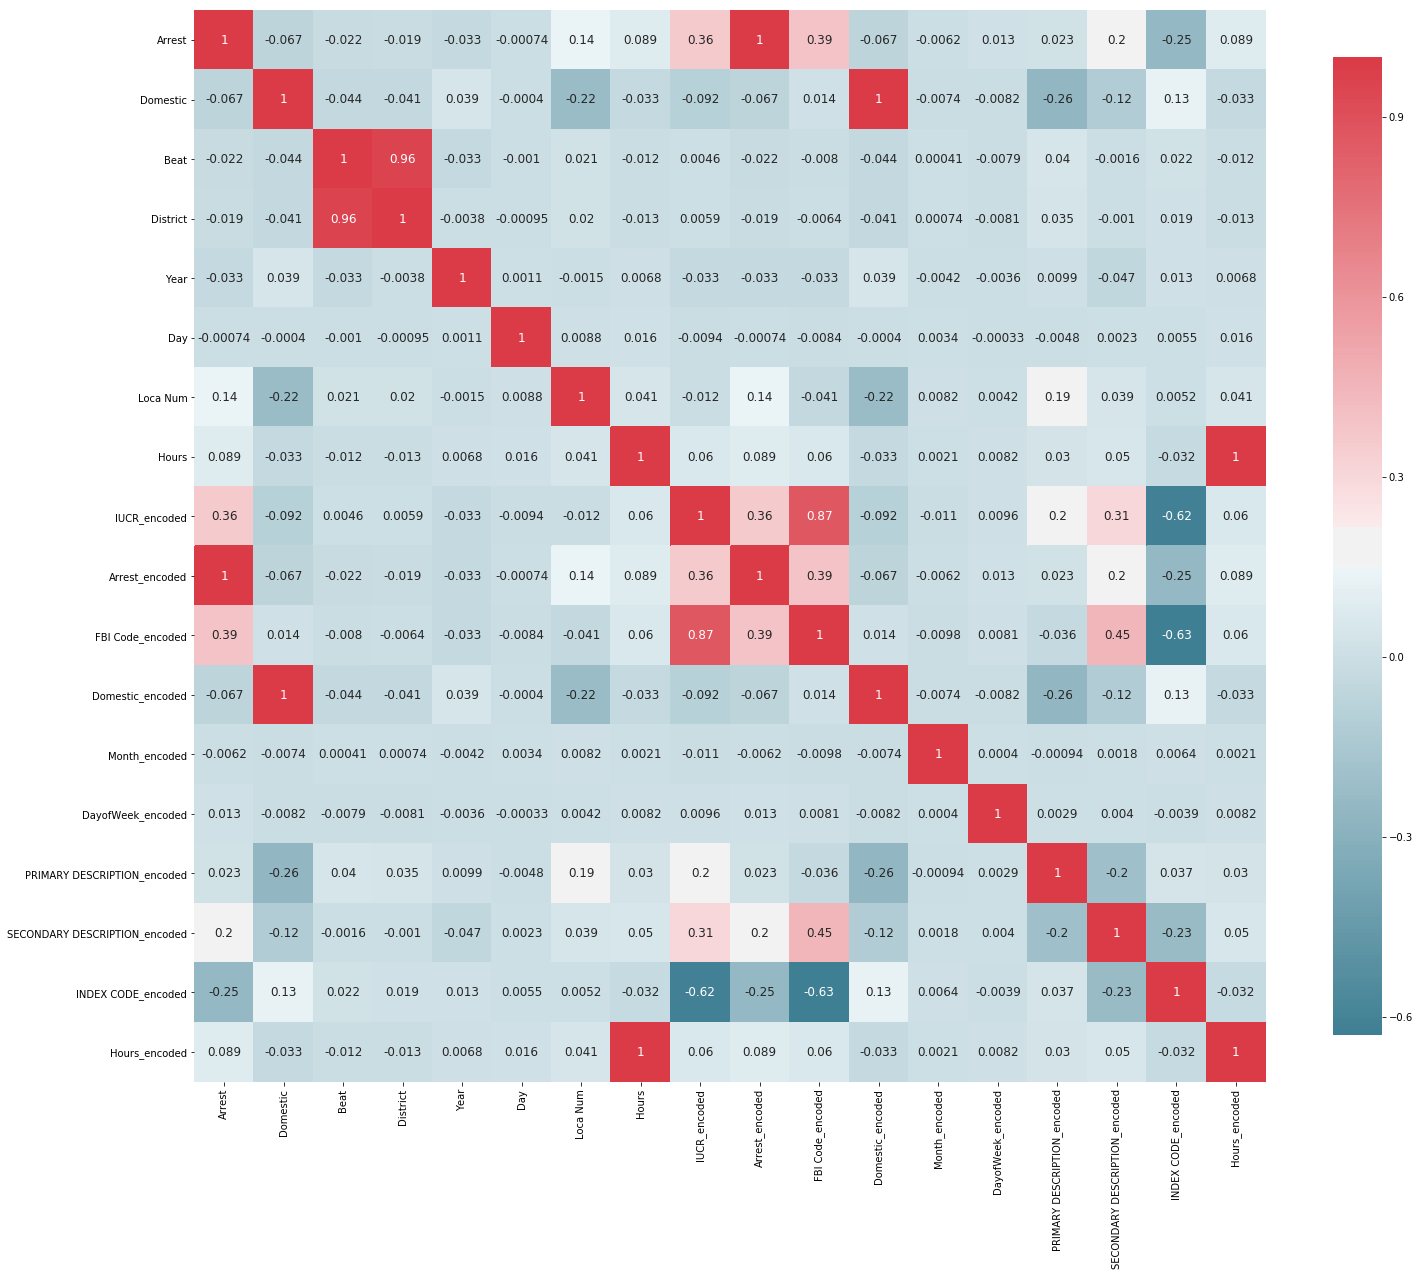

In [26]:
def plot_correlation_map(df):
    """
    This function plots the correlation map of a given dataframe
    """
    corr = df.corr()
    _ , ax = plt.subplots( figsize =(24, 20 ) )
    cmap = sns.diverging_palette(220, 10, as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )


plot_correlation_map(newDf)
newDf.corr()

In [27]:
# MODEL FEATURES: TIME, LOCATION, determine TYPE 
location = newDf['Loca Num']
train1 = newDf[['Month_encoded', 'DayofWeek_encoded',
           'PRIMARY DESCRIPTION_encoded', 'Hours', 'District']]


# split our data into train and test
x_train , x_test , y_train , y_test = train_test_split(train1 , location , test_size = 0.30,random_state =2)

In [29]:
# initializing Linear Regression as 'reg'
#lreg = LinearRegression()

# fit our train and test data into the linear regression model
#lreg.fit(x_train,y_train)

# get predictions 
#pred = lreg.predict(x_test)

# get the accuracy of the model
#lreg.score(y_test, pred) #very low 

In [43]:
# build random forest model

# count time building the model 
time_start = time.clock()

trees = 35
depth = 15

rf = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf.fit(x_train, y_train)

pred = rf.predict(x_test)
comparison = pd.crosstab(y_test, pred)

time1 = (time.clock() - time_start)


print("Time to build a Random Forest Model is:", time1)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred))

Time to build a Random Forest Model is: 321.88747
Test Accuracy:  0.5850012998406113


In [44]:
# count time building the model 
time_start = time.clock()

trees = 35
depth = 5

rf2 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf2.fit(x_train, y_train)

pred2 = rf2.predict(x_test)
comparison2 = pd.crosstab(y_test, pred2)

time2 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time2)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred2))

time to build a Random Forest Model is: 158.120453
Test Accuracy:  0.5487527858943438


In [45]:
# count time building the model 
time_start = time.clock()

trees = 15
depth = 15

rf3 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf3.fit(x_train, y_train)

pred3 = rf3.predict(x_test)
comparison3 = pd.crosstab(y_test, pred3)

time3 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time3)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred3))

time to build a Random Forest Model is: 144.13934900000004
Test Accuracy:  0.5844735742890553


In [46]:
# count time building the model 
time_start = time.clock()

trees = 50
depth = 15

rf4 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf4.fit(x_train, y_train)

pred4 = rf4.predict(x_test)
comparison4 = pd.crosstab(y_test, pred4)

time4 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time4)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred4))

time to build a Random Forest Model is: 453.953808
Test Accuracy:  0.5849944841969565


In [47]:
# count time building the model 
time_start = time.clock()

trees = 100
depth = 15

rf5 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf5.fit(x_train, y_train)

pred5 = rf5.predict(x_test)
comparison5 = pd.crosstab(y_test, pred5)

time5 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time5)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred5))

time to build a Random Forest Model is: 901.5171269999998
Test Accuracy:  0.5851979798432208


In [49]:
# count time building the model 
time_start = time.clock()

trees = 15
depth = 25

rf6 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf6.fit(x_train, y_train)

pred6 = rf6.predict(x_test)
comparison6 = pd.crosstab(y_test, pred6)

time6 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time6)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred6))

time to build a Random Forest Model is: 149.25837899999988
Test Accuracy:  0.5466486993317748


In [50]:
# count time building the model 
time_start = time.clock()

trees = 15
depth = 35

rf7 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf7.fit(x_train, y_train)

pred7 = rf7.predict(x_test)
comparison7 = pd.crosstab(y_test, pred7)

time7 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time7)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred7))

time to build a Random Forest Model is: 159.5784209999997
Test Accuracy:  0.5428592014597161


In [56]:
# count time building the model 
time_start = time.clock()

trees = 15
depth = 5

rf8 = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
rf8.fit(x_train, y_train)

pred8 = rf8.predict(x_test)
comparison8 = pd.crosstab(y_test, pred8)

time8 = (time.clock() - time_start)
print("time to build a Random Forest Model is:", time8)
print("Test Accuracy: ", metrics.accuracy_score(y_test, pred8))

time to build a Random Forest Model is: 64.82272700000249
Test Accuracy:  0.5473146850831849


<Figure size 432x288 with 0 Axes>

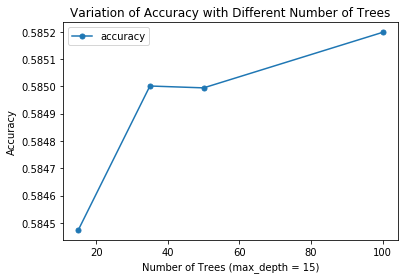

In [72]:
# diff number of trees 
# depth = 15

d = pd.DataFrame(
    data = {'ntree': [15, 35, 50, 100], 
            'accuracy': [metrics.accuracy_score(y_test, pred3),
                         metrics.accuracy_score(y_test, pred),
                         metrics.accuracy_score(y_test, pred4),
                         metrics.accuracy_score(y_test, pred5)]})

plt.figure()
d.plot(x = 'ntree', y = 'accuracy', marker='.', markersize=10, 
       title='Variation of Accuracy with Different Number of Trees')

plt.xlabel("Number of Trees (max_depth = 15)")
plt.ylabel("Accuracy")
plt.savefig('num_tree.png')
plt.show()

<Figure size 432x288 with 0 Axes>

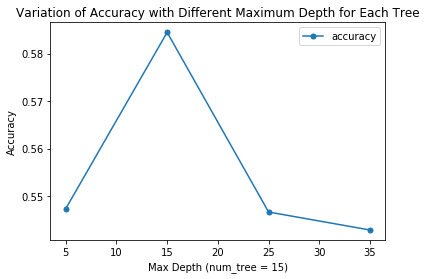

In [70]:
# diff number of max_depth
# trees = 15

d2 = pd.DataFrame(
    data = {'max_depth': [5, 15, 25, 35], 
            'accuracy': [metrics.accuracy_score(y_test, pred8),
                         metrics.accuracy_score(y_test, pred3),
                         metrics.accuracy_score(y_test, pred6),
                         metrics.accuracy_score(y_test, pred7)]})
            #'time': [time8, time3, time6, time7]})

plt.figure()
d2.plot(x = 'max_depth', y = 'accuracy', marker='.', markersize=10, 
       title='Variation of Accuracy with Different Maximum Depth for Each Tree')

plt.xlabel("Max Depth (num_tree = 15)")
plt.ylabel("Accuracy")
plt.savefig('max_depth.png')
plt.show()

### using rf with trees=35 and depth=15 

In [73]:
# displays the precision, recall, F1, and support scores for the model

# Precision is the ability of a classiifer not to label an instance positive that is actually negative. 
# for all instances classified positive, what percent was correct

# Recall is the ability of a classifier to find all positive instances.
# for all instances that were actually positive, what percent was classified correctly

# The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0

# Support is the number of actual occurrences of the class in the specified dataset. 

report =  metrics.classification_report(y_test, pred)
print(report)

             precision    recall  f1-score   support

          0       0.27      0.01      0.01     48043
          1       0.58      0.64      0.61    349275
          2       0.61      0.74      0.67    455281
          3       0.46      0.26      0.33    144915
          4       0.33      0.00      0.01     29535

avg / total       0.55      0.59      0.55   1027049



Confusion matrix, without normalization
[[   345  18033  22349   7290     26]
 [   140 223345 112812  12891     87]
 [   335  94003 338938  21894    111]
 [   417  42618  63771  38064     45]
 [    62   6756  19390   3194    133]]


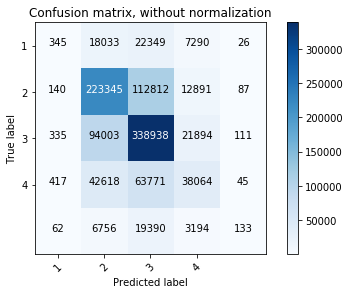

In [74]:
# confusion matrix 
# https://towardsdatascience.com/demystifying-confusion-matrix-confusion-9e82201592fd

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix, without normalization')
plt.savefig('rf_cm_wo_normal.png')
plt.show()

Normalized confusion matrix
[[0.01 0.38 0.47 0.15 0.  ]
 [0.   0.64 0.32 0.04 0.  ]
 [0.   0.21 0.74 0.05 0.  ]
 [0.   0.29 0.44 0.26 0.  ]
 [0.   0.23 0.66 0.11 0.01]]


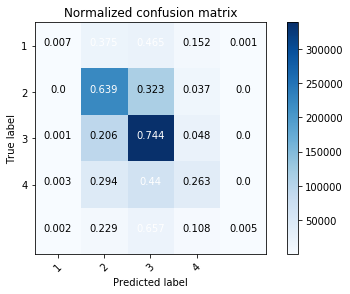

In [75]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('rf_cm_w_normal.png')
plt.show()

### Feature Importanace

In [77]:
featureImp = pd.DataFrame(
    {"Features": train1.columns.tolist(),
     "Feature Importance": rf.feature_importances_.tolist()  
    })
featureImp["Features"] = featureImp["Features"].str.replace('_encoded', '', regex=True)
featureImp.sort_values(by = "Feature Importance" , ascending=False)

,Features,Feature Importance
2,PRIMARY DESCRIPTION,0.697917
4,District,0.118878
3,Hours,0.115968
0,Month,0.036127
1,DayofWeek,0.031111


<Figure size 432x288 with 0 Axes>

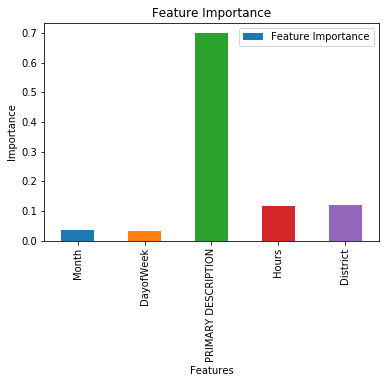

In [78]:
# plot feature importance 

plt.figure()
featureImp.plot.bar(x = 'Features', y = 'Feature Importance', 
       title='Feature Importance')

plt.xlabel("Features")
plt.ylabel("Importance")
plt.savefig('rd_feature_imp.png')
plt.show()

In [ ]:
# count time building the model 
#time_start = time.clock()

#trees = 1000
#depth = 15

#rf = ensemble.RandomForestClassifier(n_estimators=trees, max_depth=depth)
#rf.fit(x_train, y_train)

#pred = rf.predict(x_test)
#comparison = pd.crosstab(y_test, pred)

#time1 = (time.clock() - time_start)
#print("time to build a Random Forest Model is:", time1)
#print("mean accuracy on the given test data and labels is:", rf.score(x_test,y_test))

In [ ]:
# The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting 
# so a large number usually results in better performance.

# count time building the model 
time_start = time.clock()

gbr = ensemble.GradientBoostingRegressor(n_estimators = 35, max_depth = 5,
                                         loss = 'ls')

gbr.fit(x_train, y_train)
gbr_pred = gbr.predict(x_test)
gbr_comparison = pd.crosstab(y_test, gbr_pred)

grd_time = (time.clock() - time_start)
print("time to build a Gradient Boosting Model is:", grd_time)
print("Test Accuracy: ", metrics.accuracy_score(y_test, gbr_pred))

In [ ]:
report =  metrics.classification_report(y_test, gbr_pred)
print(report)

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, gbr_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix, without normalization')
plt.savefig('gbr_cm_wo_normal.png')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('gbr_cm_w_normal.png')
plt.show()

### neural network

In [5]:
# https://towardsdatascience.com/deep-learning-for-beginners-practical-guide-with-python-and-keras-d295bfca4487


y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# count time building the model 
time_start = time.clock()

nn = Sequential()
nn.add(Dense(128, input_dim=5, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(128, activation='tanh'))
nn.add(Dense(5, activation='softmax'))
nn.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

nn.fit(x_train, y_train, batch_size=128, epochs=5)
nn_pred = model.predict_classes(x_test)

nn_time = (time.clock() - time_start)
print("time to build a Neural Network Model is:", nn_time)
print("Test Accuracy: ", metrics.accuracy_score(y_test, nn_pred))

NameError: name 'y_train' is not defined

In [ ]:
report =  metrics.classification_report(y_test, nn_pred)
print(report)

In [ ]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, nn_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4],
                      title='Confusion matrix, without normalization')
plt.savefig('nn_cm_wo_normal.png')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[1,2,3,4], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('nn_cm_w_normal.png')
plt.show()